In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel("Online_Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
import seaborn as sns
sns.set_palette("husl")
sns.set(rc={'image.cmap': 'coolwarm'})
%matplotlib inline

In [4]:
import datetime as dt
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date

In [5]:
df = df[pd.notnull(df['CustomerID'])]
df = df[(df['Quantity']>0)]

In [6]:
df['Sales'] = df['Quantity'] * df['UnitPrice']
cols_of_interest = ['CustomerID', 'InvoiceDate', 'Sales']
df = df[cols_of_interest]

In [7]:
print(df.head())
print(df['CustomerID'].nunique())

   CustomerID InvoiceDate  Sales
0     17850.0  2010-12-01  15.30
1     17850.0  2010-12-01  20.34
2     17850.0  2010-12-01  22.00
3     17850.0  2010-12-01  20.34
4     17850.0  2010-12-01  20.34
4339


In [8]:
#%pip install lifetimes==0.10.1
from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes.estimation import *

data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end='2011-12-9')
data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
0.3569946992394561


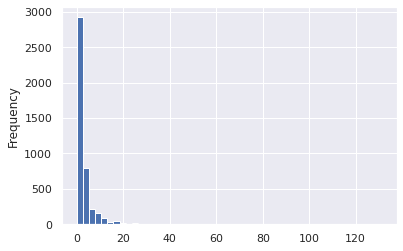

In [9]:
data['frequency'].plot(kind='hist', bins=50)
print(data['frequency'].describe())
print(sum(data['frequency'] == 0)/float(len(data)))

In [10]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.93, b: 2.24, r: 0.83>


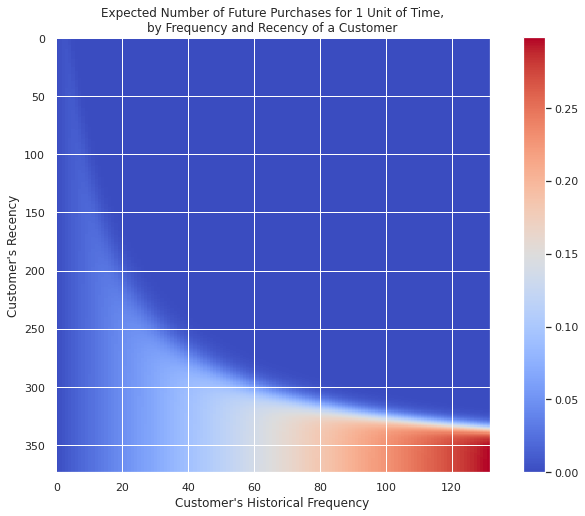

In [11]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

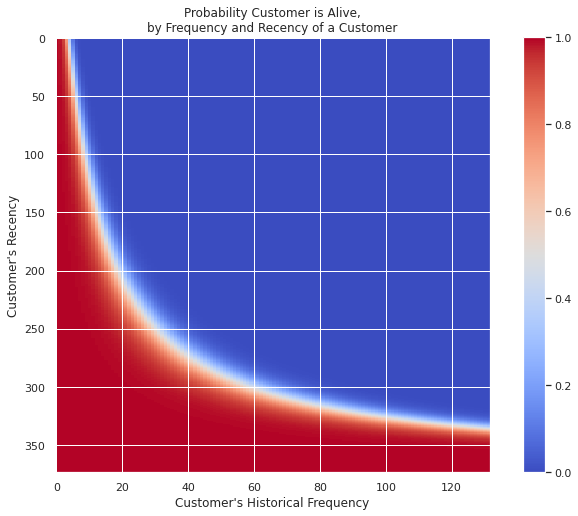

In [12]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

In [13]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606.0,88.0,372.0,373.0,135.890114,0.200992
15311.0,89.0,373.0,373.0,677.729438,0.203255
17841.0,111.0,372.0,373.0,364.452162,0.253035
12748.0,113.0,373.0,373.0,298.360885,0.257562
14911.0,131.0,372.0,373.0,1093.661679,0.298291


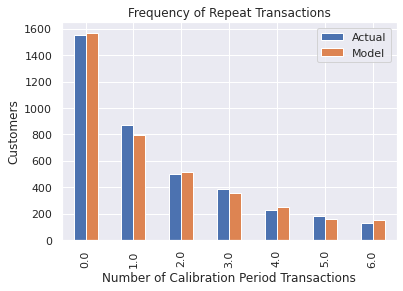

In [14]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [57]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-08',
                                        observation_period_end='2011-12-09' )   

print(summary_cal_holdout.head())


            frequency_cal  recency_cal  ...  frequency_holdout  duration_holdout
CustomerID                              ...                                     
12346.0               0.0          0.0  ...                0.0               184
12347.0               2.0        121.0  ...                4.0               184
12348.0               2.0        110.0  ...                1.0               184
12350.0               0.0          0.0  ...                0.0               184
12352.0               3.0         34.0  ...                3.0               184

[5 rows x 5 columns]


In [72]:
print(summary_cal_holdout)

            frequency_cal  recency_cal  ...  frequency_holdout  duration_holdout
CustomerID                              ...                                     
12346.0               0.0          0.0  ...                0.0               184
12347.0               2.0        121.0  ...                4.0               184
12348.0               2.0        110.0  ...                1.0               184
12350.0               0.0          0.0  ...                0.0               184
12352.0               3.0         34.0  ...                3.0               184
...                   ...          ...  ...                ...               ...
18272.0               1.0         21.0  ...                4.0               184
18273.0               0.0          0.0  ...                2.0               184
18280.0               0.0          0.0  ...                0.0               184
18283.0               4.0        137.0  ...                9.0               184
18287.0               0.0   

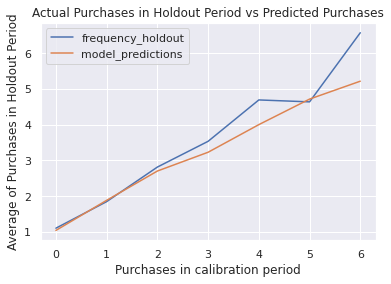

In [58]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [59]:
t = 10 #predict purchases in 10 periods
individual = data.loc[12347]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.15727889529134048

In [60]:
data.loc[12347]

frequency                6.000000
recency                365.000000
T                      367.000000
monetary_value         599.701667
predicted_purchases      0.015657
Name: 12347.0, dtype: float64

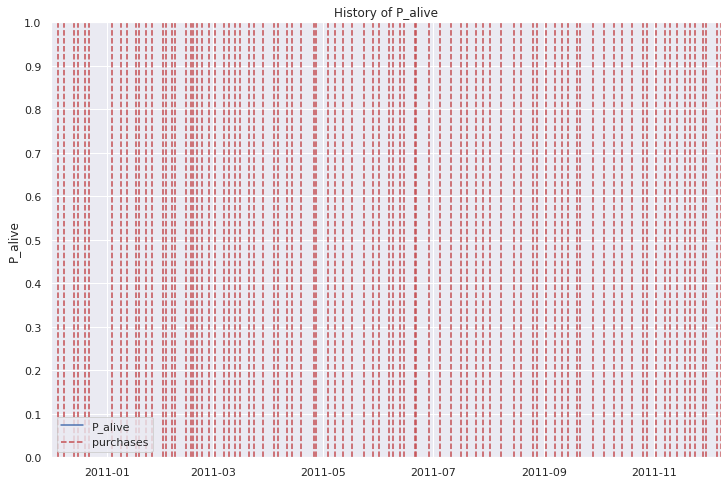

In [77]:
from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,8))
id =  14606
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

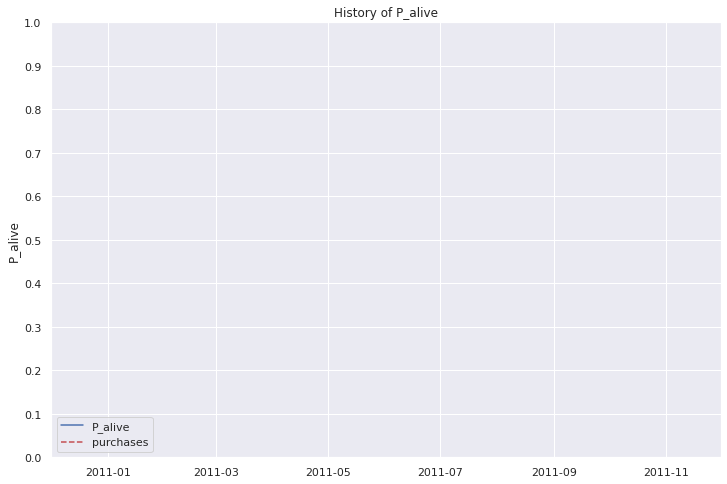

In [80]:
fig = plt.figure(figsize=(12,8))
id = 14729
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

In [81]:
returning_customers_summary = data[data['frequency']>0]

print(returning_customers_summary.head())
print(len(returning_customers_summary))

            frequency  recency      T  monetary_value  predicted_purchases
CustomerID                                                                
12347.0           6.0    365.0  367.0      599.701667             0.015657
12348.0           3.0    283.0  358.0      301.480000             0.008957
12352.0           6.0    260.0  296.0      368.256667             0.018700
12356.0           2.0    303.0  325.0      269.905000             0.007172
12358.0           1.0    149.0  150.0      683.200000             0.008339
2790


In [82]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.015882
frequency,0.015882,1.000000


In [83]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


In [84]:
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(10))

CustomerID
12346.0    416.917640
12347.0    569.988801
12348.0    333.762666
12349.0    416.917640
12350.0    416.917640
12352.0    376.166860
12353.0    416.917640
12354.0    416.917640
12355.0    416.917640
12356.0    324.008932
dtype: float64


In [85]:
bgf.fit(data['frequency'], data['recency'], data['T'])

print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    data['frequency'],
    data['recency'],
    data['T'],
    data['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))

CustomerID
12346.0     295.315859
12347.0    3012.093114
12348.0    1009.042108
12349.0    1337.176562
12350.0     307.001953
12352.0    2374.004231
12353.0     426.181364
12354.0     386.542842
12355.0     411.124407
12356.0     784.310784
Name: clv, dtype: float64
